In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import grad
import numpy as np
from torch.nn.attention import sdpa_kernel,SDPBackend
# ----- Version Compatibility ----- #
# This code is compatible with:
# Python: 3.9+
# PyTorch: 2.0+

# ----- Synthetic Dataset (Copy Task) ----- #
class CopyDataset(Dataset):
    def __init__(self, num_samples=1000, seq_len=100, vocab_size=50):
        self.data = torch.randint(1, vocab_size, (num_samples, seq_len))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = x.clone()  # Copy task
        return x, y

class ReverseDataset(Dataset):
    def __init__(self, num_samples=1000, seq_len=15, vocab_size=50):
        self.data = torch.randint(1, vocab_size, (num_samples, seq_len))
        for i in range(len(self.data)):
            self.data[i][np.random.randint(0,14)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y =torch.flip(x.clone(),dims=[0])  # Copy task
        return x, y
    

import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Create a matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        # Compute the positional encodings once in log space.
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        seq_len = x.size(1)
        # Add positional encoding to input embeddings.
        x = x + self.pe[:, :seq_len, :]
        return x


# ----- Transformer Model (No FlashAttention) ----- #
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=4, nhead=2, num_layers=1,ff=32):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len=100)
        self.attention_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model, 
                nhead=nhead, 
                batch_first=True, 
                activation='relu', 
                norm_first=True,
                dim_feedforward=ff
            ) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src):
        
        embedded = self.embedding(src)

        embedded = self.pos_encoding(embedded)
        for layer in self.attention_layers:
            embedded = layer(embedded)
        output = self.fc_out(embedded)
        return output
 #

    # Hyperparameters
vocab_size = 50
seq_len = 15
batch_size = 100
epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d_model=4
nhead=2
num_layers=1
ff=8



In [24]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torch.nn.attention import sdpa_kernel, SDPBackend
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Create a matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        # Compute the positional encodings once in log space.
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        seq_len = x.size(1)
        # Add positional encoding to input embeddings.
        x = x + self.pe[:, :seq_len, :]
        return x
    
# ----- Modified Dataset for Variable Length Sequences ----- #
class ReverseDataset(Dataset):
    def __init__(self, num_samples=1000, min_seq_len=5, max_seq_len=15, vocab_size=50):
        self.data = []
        self.vocab_size = vocab_size
        for _ in range(num_samples):
            seq_len = np.random.randint(min_seq_len, max_seq_len + 1)
            # Generate a random sequence with values in 1 ... vocab_size-1 (reserve 0 for padding)
            seq = torch.randint(1, vocab_size, (seq_len,))
            self.data.append(seq)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = torch.flip(x.clone(), dims=[0])
        return x, y

# ----- Custom Collate Function for Padding ----- #
def collate_fn(batch):
    xs, ys = zip(*batch)
    # Determine the maximum length in the batch
    max_len = max([len(x) for x in xs])
    
    # Pad sequences with 0 (assumed pad token) to max_len
    padded_xs = torch.stack([torch.cat([x, torch.zeros(max_len - len(x), dtype=torch.long)]) for x in xs])
    padded_ys = torch.stack([torch.cat([y, torch.zeros(max_len - len(y), dtype=torch.long)]) for y in ys])
    
    return padded_xs, padded_ys


In [25]:


class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=4, nhead=2, num_layers=1, ff=32, max_len=50):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoding = PositionalEncoding(d_model, max_len=max_len)
        self.attention_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model, 
                nhead=nhead, 
                batch_first=True, 
                activation='relu', 
                norm_first=True,
                dim_feedforward=ff
            ) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src, src_key_padding_mask=None):
        """
        src: (batch_size, seq_len) of token indices.
        src_key_padding_mask: (batch_size, seq_len) where True indicates padded positions.
        """
        # Embedding: (batch_size, seq_len, d_model)
        embedded = self.embedding(src)
        # Apply positional encoding
        embedded = self.pos_encoding(embedded)
        # Pass through transformer layers (each can use the padding mask)
        for layer in self.attention_layers:
            embedded = layer(embedded, src_key_padding_mask=src_key_padding_mask)
        # Output layer: (batch_size, seq_len, vocab_size)
        output = self.fc_out(embedded)
        return output

vocab_size = 50
seq_len = 15
batch_size = 100
epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d_model=16
nhead=4
num_layers=2
ff=32
max_seq_len = 15

def create_padding_mask(batch):
    # Here, padded tokens are 0. Return mask of shape (batch_size, seq_len)
    return batch == 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleTransformer(vocab_size=vocab_size, d_model=d_model, nhead=nhead, num_layers=num_layers, ff=ff, max_len=max_seq_len+1)
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # ignore padded tokens
optimizer = optim.Adam(model.parameters(), lr=0.01)

dataset = ReverseDataset(num_samples=1000, min_seq_len=5, max_seq_len=max_seq_len, vocab_size=vocab_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


In [26]:
dataset = CopyDataset()
testset= CopyDataset()
dataloader1 = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader2 = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [28]:
dataset1 = ReverseDataset(num_samples=1000, min_seq_len=5, max_seq_len=max_seq_len, vocab_size=vocab_size)
dataloader1 = DataLoader(dataset1, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dataset2 = ReverseDataset(num_samples=1000, min_seq_len=5, max_seq_len=max_seq_len, vocab_size=vocab_size)
dataloader2 = DataLoader(dataset1, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [377]:
dataset = ReverseDataset()
testset= ReverseDataset()
dataloader1 = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader2 = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [41]:
#Different
vocab_size = 50
seq_len = 15
batch_size = 100
epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d_model=16
nhead=4
num_layers=2
ff=16
max_seq_len = 15

epochs=5000
#with sdpa_kernel([SDPBackend.MATH]):
model = SimpleTransformer(vocab_size,d_model=d_model,ff=ff,nhead=nhead,num_layers=num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
TrainErrorAdam = []
TestErrorAdam=[]
for epoch in range(epochs):
    # Training Phase
    model.train()
    total_loss = 0
    for batch in dataloader1:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        pad_mask = create_padding_mask(inputs).to(device)

        optimizer.zero_grad()
        outputs = model(inputs, src_key_padding_mask=pad_mask)  # (batch_size, seq_len, vocab_size)
        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(dataloader1)

    # Validation Phase
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in dataloader2:
            inputs, targets = batch

            inputs, targets = inputs.to(device), targets.to(device)
            pad_mask = create_padding_mask(inputs).to(device)

            
            outputs = model(inputs, src_key_padding_mask=pad_mask)
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
            test_loss += loss.item()
    avg_test_loss = test_loss / len(dataloader2)
    
    TrainErrorAdam.append(avg_train_loss)
    TestErrorAdam.append(avg_test_loss)
    if epoch%100==0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:3g}")
        print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {avg_test_loss:.3g}")

#with sdpa_kernel([SDPBackend.MATH]):


Epoch [1/5000], Loss: 3.56648
Epoch [1/5000], Test Loss: 2.96
Epoch [101/5000], Loss: 0.740217
Epoch [101/5000], Test Loss: 0.293
Epoch [201/5000], Loss: 0.523705
Epoch [201/5000], Test Loss: 0.108
Epoch [301/5000], Loss: 0.434704
Epoch [301/5000], Test Loss: 0.0684
Epoch [401/5000], Loss: 0.389205
Epoch [401/5000], Test Loss: 0.0361
Epoch [501/5000], Loss: 0.335856
Epoch [501/5000], Test Loss: 0.0277
Epoch [601/5000], Loss: 0.352276
Epoch [601/5000], Test Loss: 0.0345
Epoch [701/5000], Loss: 0.413951
Epoch [701/5000], Test Loss: 0.0494
Epoch [801/5000], Loss: 0.337709
Epoch [801/5000], Test Loss: 0.0335
Epoch [901/5000], Loss: 0.318842
Epoch [901/5000], Test Loss: 0.0287
Epoch [1001/5000], Loss: 0.315125
Epoch [1001/5000], Test Loss: 0.0298
Epoch [1101/5000], Loss: 0.317629
Epoch [1101/5000], Test Loss: 0.0288
Epoch [1201/5000], Loss: 0.31586
Epoch [1201/5000], Test Loss: 0.0479
Epoch [1301/5000], Loss: 0.315725
Epoch [1301/5000], Test Loss: 0.0235
Epoch [1401/5000], Loss: 0.324696
Ep

In [ ]:
model2 = SimpleTransformer(vocab_size,d_model=d_model,ff=ff,nhead=nhead,num_layers=num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=.1)
TrainErrorSGD = []
TestErrorSGD=[]
epochs=5000
TrainErrorSGD = []
TestErrorSGD=[]
for epoch in range(epochs):
    # Training Phase
    model2.train()
    total_loss = 0
    for batch in dataloader1:
       
        
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        pad_mask = create_padding_mask(inputs).to(device)

        optimizer.zero_grad()
        outputs = model2(inputs, src_key_padding_mask=pad_mask)  # (batch_size, seq_len, vocab_size)
        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(dataloader1)

    # Validation Phase
    model2.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in dataloader2:
            inputs, targets = batch

            inputs, targets = inputs.to(device), targets.to(device)
            pad_mask = create_padding_mask(inputs).to(device)

            
            outputs = model2(inputs, src_key_padding_mask=pad_mask)
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
            test_loss += loss.item()
    avg_test_loss = test_loss / len(dataloader2)
    
    TrainErrorSGD.append(avg_train_loss)
    TestErrorSGD.append(avg_test_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:3g}")
    print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {avg_test_loss:.3g}")

#with sdpa_kernel([SDPBackend.MATH]):


(tensor([[39, 36, 32,  ...,  0,  0,  0],
        [33,  6, 28,  ...,  0,  0,  0],
        [27, 12, 36,  ..., 12,  3, 12],
        ...,
        [45,  8, 22,  ...,  9, 23, 42],
        [33,  7, 21,  ..., 31,  0,  0],
        [43,  1, 24,  ...,  0,  0,  0]]), tensor([[28,  1, 32,  ...,  0,  0,  0],
        [43,  9,  3,  ...,  0,  0,  0],
        [12,  3, 12,  ..., 36, 12, 27],
        ...,
        [42, 23,  9,  ..., 22,  8, 45],
        [31, 39, 25,  ..., 33,  0,  0],
        [44, 39, 29,  ...,  0,  0,  0]]))
Epoch [1/5000], Loss:   0
Epoch [1/5000], Test Loss: 3.97
(tensor([[46,  8, 49,  ...,  0,  0,  0],
        [31, 34,  2,  ...,  0,  0,  0],
        [ 7,  6, 31,  ...,  0,  0,  0],
        ...,
        [20,  4,  1,  ...,  0,  0,  0],
        [ 1, 41, 18,  ..., 44,  0,  0],
        [ 7, 39, 45,  ..., 25, 27,  0]]), tensor([[34, 42, 32,  ...,  0,  0,  0],
        [38, 22, 28,  ...,  0,  0,  0],
        [11,  1, 21,  ...,  0,  0,  0],
        ...,
        [ 9, 38,  1,  ...,  0,  0,  0],
  

KeyboardInterrupt: 

In [ ]:
#Normal
epochs=1000
with sdpa_kernel([SDPBackend.MATH]):
    model = SimpleTransformer(vocab_size,d_model=d_model,ff=ff,nhead=nhead,num_layers=num_layers).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    TrainErrorAdam = []
    TestErrorAdam=[]
    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_loss = 0
        for batch in dataloader1:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()  # Fixed typo here.
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(dataloader1)

        # Validation Phase
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch in dataloader2:
                inputs, targets = batch
                print(inputs)
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
                test_loss += loss.item()
        avg_test_loss = test_loss / len(dataloader2)
        
        TrainErrorAdam.append(avg_train_loss)
        TestErrorAdam.append(avg_test_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:3g}")
        print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {avg_test_loss:.3g}")

with sdpa_kernel([SDPBackend.MATH]):
    model2 = SimpleTransformer(vocab_size,d_model=d_model,ff=ff,nhead=nhead,num_layers=num_layers).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model2.parameters(), lr=.1)
    TrainErrorSGD = []
    TestErrorSGD=[]
    for epoch in range(epochs):
        # Training Phase
        model2.train()
        total_loss = 0
        for batch in dataloader1:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()  # Fixed typo here.
            outputs = model2(inputs)
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(dataloader1)

        # Validation Phase
        model2.eval()
        test_loss = 0
        with torch.no_grad():
            for batch in dataloader2:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model2(inputs)
                loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
                test_loss += loss.item()
        avg_test_loss = test_loss / len(dataloader2)
        
        TrainErrorSGD.append(avg_train_loss)
        TestErrorSGD.append(avg_test_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:3g}")
        print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {avg_test_loss:.3g}")

tensor([[49,  9, 15,  ..., 39,  8,  0],
        [39,  9, 15,  ...,  0,  0,  0],
        [27,  1, 36,  ...,  0,  0,  0],
        ...,
        [15, 31, 18,  ...,  0,  0,  0],
        [13, 35, 45,  ...,  0,  0,  0],
        [41,  3, 11,  ..., 15,  6,  0]])
tensor([[ 4,  8, 13,  ...,  0,  0,  0],
        [27, 41, 46,  ...,  0,  0,  0],
        [18, 46,  5,  ...,  1,  0,  0],
        ...,
        [27,  1, 10,  ...,  0,  0,  0],
        [28,  4, 36,  ...,  0,  0,  0],
        [12, 21, 37,  ...,  0,  0,  0]])
tensor([[26,  5,  4,  ...,  0,  0,  0],
        [ 7, 47,  1,  ...,  0,  0,  0],
        [ 3,  2, 46,  ...,  0,  0,  0],
        ...,
        [44, 12, 12,  ...,  0,  0,  0],
        [22, 29, 13,  ..., 30,  5,  0],
        [43, 32, 21,  ...,  0,  0,  0]])
tensor([[46, 43, 46,  ...,  0,  0,  0],
        [29, 23, 20,  ...,  7, 22,  2],
        [24, 17,  9,  ...,  7,  0,  0],
        ...,
        [11, 11, 46,  ...,  0,  0,  0],
        [13, 40, 27,  ..., 27,  0,  0],
        [46, 25, 23,  ...

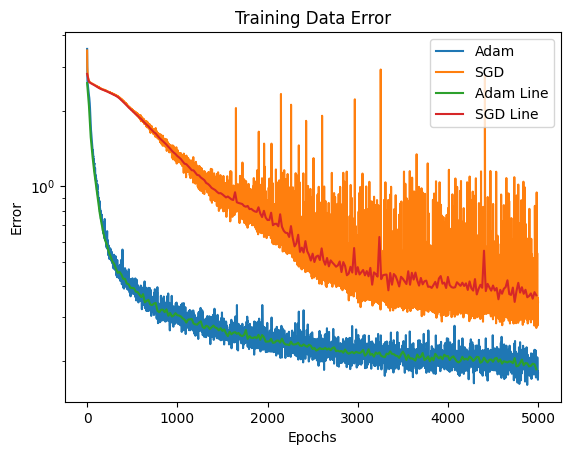

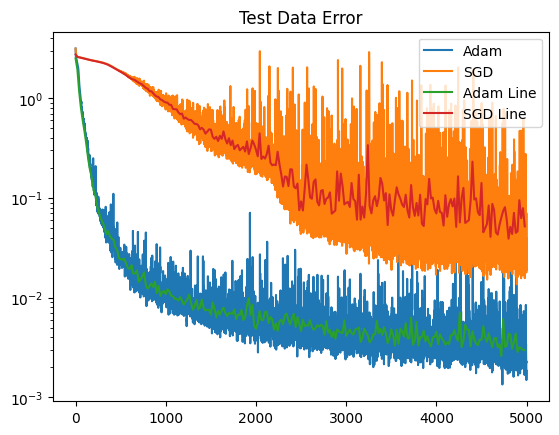

In [36]:
import matplotlib.pyplot as plt
n=20
TestLineAdam=[]
for i in range(len(TestErrorAdam)//n):
    TestLineAdam.append(np.mean(TestErrorAdam[n*i:n*i+n]))

TrainLineAdam=[]
for i in range(len(TrainErrorAdam)//n):
    TrainLineAdam.append(np.mean(TrainErrorAdam[n*i:n*i+n]))

TestLineSGD=[]
for i in range(len(TestErrorSGD)//n):
    TestLineSGD.append(np.mean(TestErrorSGD[n*i:n*i+n]))

    
TrainLineSGD=[]
for i in range(len(TestErrorSGD)//n):
    TrainLineSGD.append(np.mean(TrainErrorSGD[n*i:n*i+n]))


    

plt.plot(np.arange(len(TrainErrorAdam)),TrainErrorAdam,label="Adam")
plt.plot(np.arange(len(TrainErrorSGD)),TrainErrorSGD,label="SGD")
plt.plot(np.arange(0,5000,n),TrainLineAdam,label="Adam Line")
plt.plot(np.arange(0,5000,n),TrainLineSGD,label="SGD Line")

plt.yscale('log')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Training Data Error")
plt.savefig("PicturesOnComplexity/ADAMvSGDTrainReverseAnyLength2.png")
plt.show()


plt.plot(np.arange(len(TestErrorAdam)),TestErrorAdam,label="Adam")
plt.plot(np.arange(len(TestErrorAdam)),TestErrorSGD,label="SGD")
plt.plot(np.arange(0,5000,n),TestLineAdam,label="Adam Line")
plt.plot(np.arange(0,5000,n),TestLineSGD,label="SGD Line")

plt.yscale('log')
plt.legend()
plt.title("Test Data Error")
plt.savefig("PicturesOnComplexity/ADAMvSGDTestReverseAnyLength2.png")
plt.show()



In [27]:
n=50
TestLineAdam=[]
for i in range(len(TestErrorAdam)//n):
    TestLineAdam.append(np.mean(TestErrorAdam[n*i:n*i+n]))

TrainLineAdam=[]
for i in range(len(TrainErrorAdam)//n):
    TrainLineAdam.append(np.mean(TrainErrorAdam[n*i:n*i+n]))

TestLineSGD=[]
for i in range(len(TestErrorSGD)//n):
    TestLineSGD.append(np.mean(TestErrorSGD[n*i:n*i+n]))

    
TrainLineSGD=[]
for i in range(len(TestErrorSGD)//n):
    TrainLineSGD.append(np.mean(TestErrorSGD[n*i:n*i+n]))


    

In [74]:

model.eval()  # Set the model to evaluation mode

# Example input sequence (a list of token indices)
input_sequence = [0,6,9,8,4,1,32]  # Replace with your actual token IDs
input_tensor = torch.tensor(input_sequence).unsqueeze(0).to(device)  # Shape: (1, seq_len)

# Run inference without gradient tracking
with torch.no_grad():
    output_logits = model(input_tensor)  # Output shape: (1, seq_len, vocab_size)
    # Get predicted tokens (using argmax over the vocabulary dimension)
    predicted_tokens = output_logits.argmax(dim=-1)  # Shape: (1, seq_len)

# Remove the batch dimension
predicted_tokens = predicted_tokens.squeeze(0).cpu().tolist()
print("Input Sequence:     ", input_sequence)
print("Predicted Sequence: ", predicted_tokens)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [73]:
with sdpa_kernel([SDPBackend.MATH]):
    model = SimpleTransformer(vocab_size,d_model=2,ff=8,nhead=1,num_layers=2).to(device)
    e=0
    amount=0
    for batch in dataloader1:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Fixed typo here.
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()
        model.eval()
    
        inputs,targets=next(iter(dataloader1))
        inputs,targets=inputs.to(device),targets.to(device)
        outputs=model(inputs)
        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
        e+=1
        if e==amount:
            break


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [281]:
with sdpa_kernel([SDPBackend.MATH]):
    inputs,targets=next(iter(dataloader1))
    inputs,targets=inputs.to(device),targets.to(device)
    outputs=model(inputs)
    loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
    attn="self_attn"
    l="linear"
    def clean(string):
        string=string.lstrip("attention_layers.")
        string="Layer"+string
        return string

    Hessians=dict()
    for name,p in model.named_parameters():
        if attn in name or "linear" in name:
            print(name)
            grad_flat=torch.autograd.grad(loss,p,create_graph=True,retain_graph=True)[0].flatten()
            N = grad_flat.shape[0]
            H = torch.zeros((N, N), device=p.device) 
            for i in range(N):
                # For each element in the flattened gradient, compute its gradient (the i-th row of Hessian)
                second_grad = torch.autograd.grad(grad_flat[i], p, retain_graph=True)[0]
                H[i, :] = second_grad.flatten()
            Hessians[clean(name)]=H

    KVQ=["q","k","v"]  
    for h in list(Hessians.keys()):
        if "self_attn.in" in h:
            Htemp=Hessians[h]
            for i in range(3):
                Hessians[h+"_"+KVQ[i]]=Htemp[i*d_model:(i+1)*d_model**2].T[i*d_model:(i+1)*d_model**2].T
            
            Hessians.pop(h)

attention_layers.0.self_attn.in_proj_weight
attention_layers.0.self_attn.in_proj_bias
attention_layers.0.self_attn.out_proj.weight
attention_layers.0.self_attn.out_proj.bias
attention_layers.0.linear1.weight
attention_layers.0.linear1.bias
attention_layers.0.linear2.weight
attention_layers.0.linear2.bias


In [257]:
clean("hiiii")

TypeError: lstrip arg must be None or str

In [ ]:
Hessians["attention_layers.0.self_attn.in_proj_weight"][0:16].T[0:16]

16

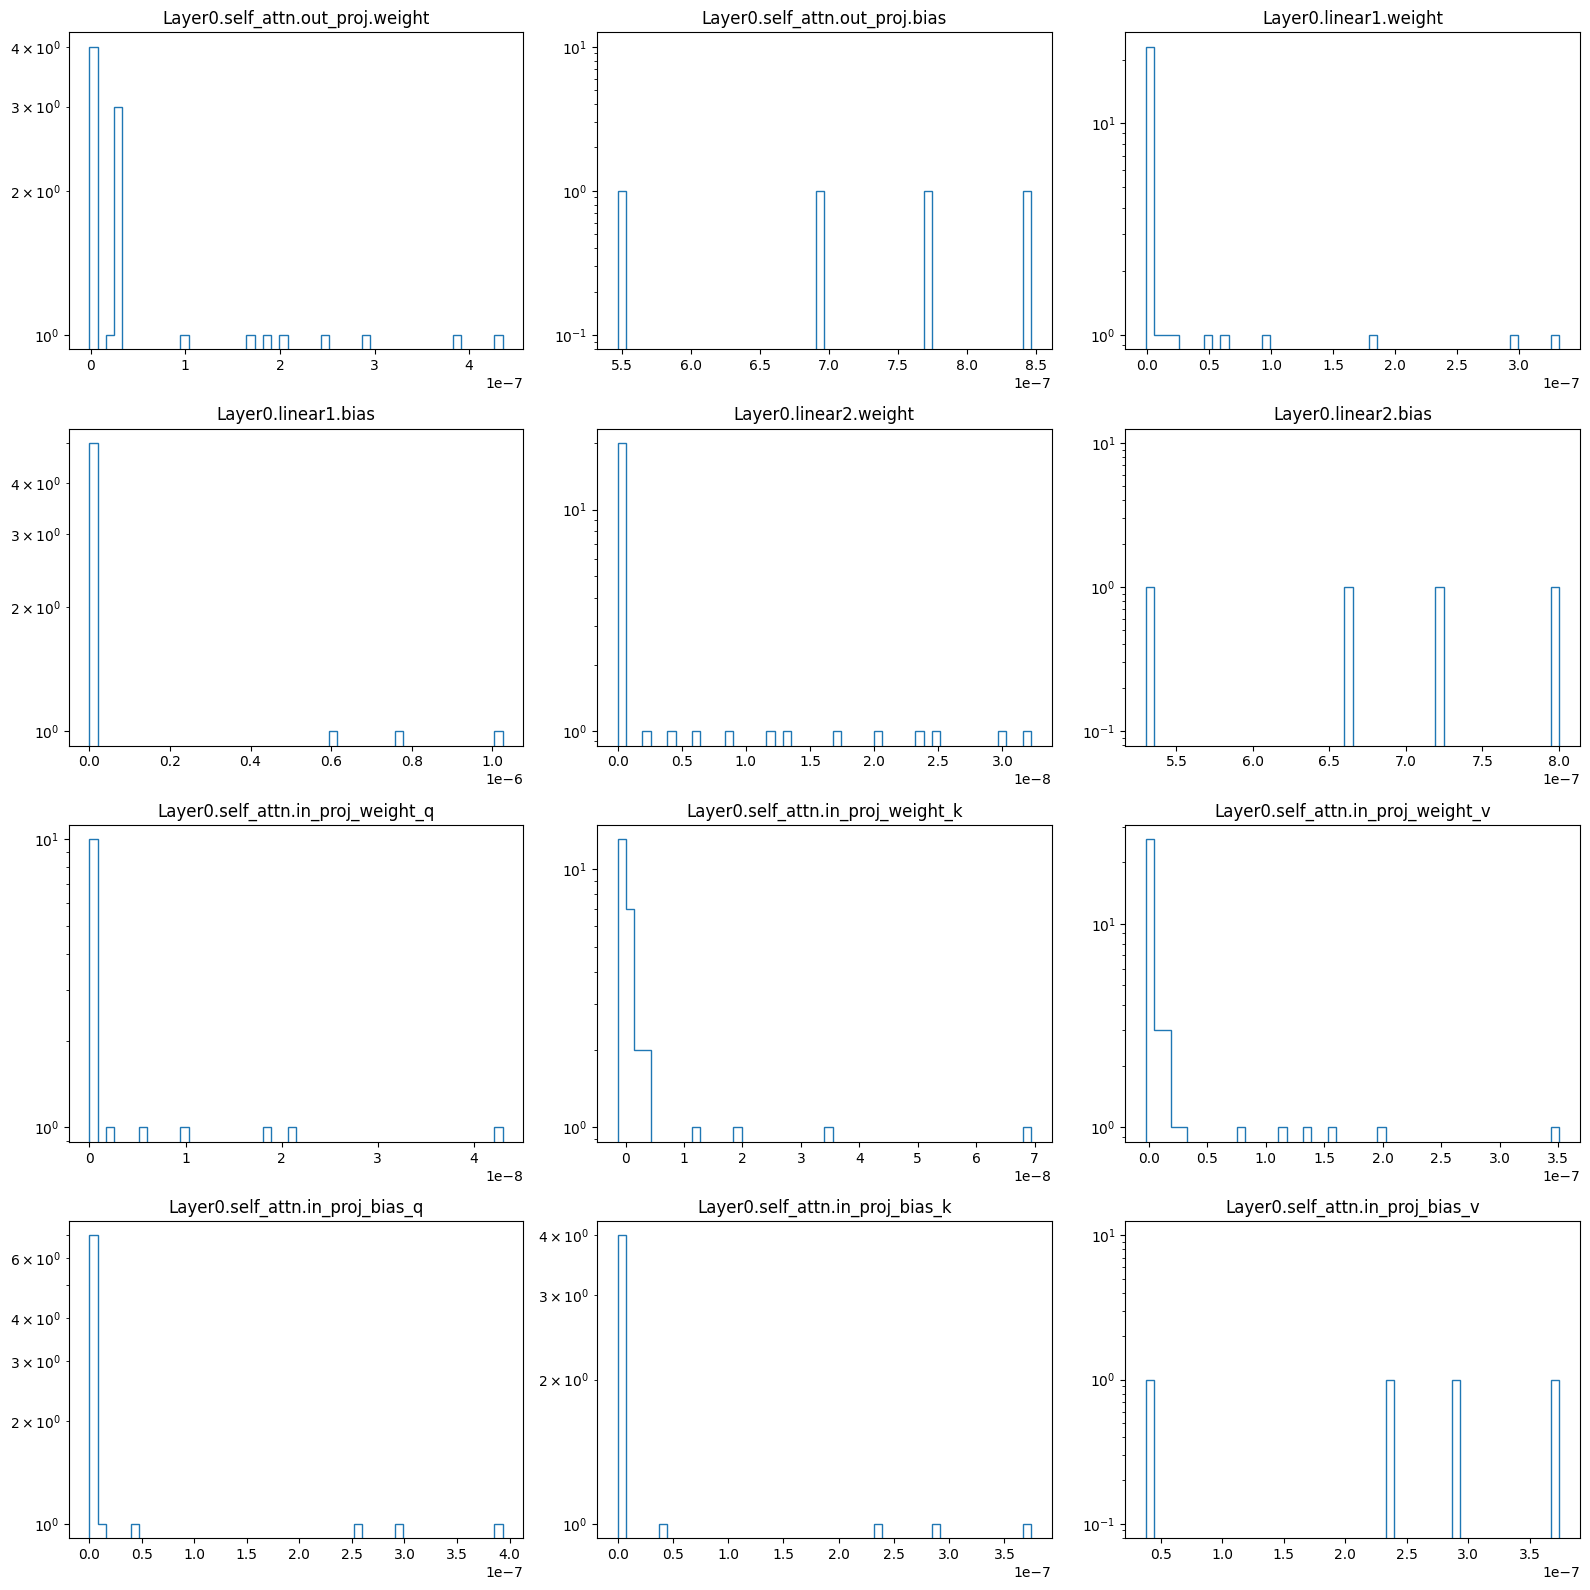

In [282]:
HessianEig=dict()
l=len(Hessians)
fig,axs=plt.subplots(l//3,3,figsize=(16, 16))
axs=axs.flatten()
for i,key in enumerate(Hessians.keys()):
    HessianEig[key]=torch.linalg.eigvalsh(Hessians[key])
    h=HessianEig[key].cpu()
    h=torch.sort(h)[0]
    axs[i].hist(h,histtype='step',bins=50)
    axs[i].set_yscale('log')
    axs[i].set_title(key)
plt.tight_layout()
plt.savefig("SmallHessianAfterTraining.png")
plt.show()

In [ ]:
for key in He

In [103]:
grad=None

In [91]:
loss

tensor(3.9423, device='cuda:0')

In [34]:
torch.cuda.is_available()

True

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import grad
import numpy as np

In [ ]:
class ContextDataset(Dataset):
    def __init__(self, num_samples=1000,d=1,n=10,V):
        self.data = torch.tensor(np.random.normal(0,1,size=[num_samples,n+1,d]))
        self.Y=[]
        for i in range(num_samples):
            x=self.data[i][0]
            X=self.data[i][1:]
            current=torch.zeros(1)
            v=torch.matmul(V,x)
            for i in range(n):
                for j in range(n):
                    current+=torch.matmul(v,X[i]-X[j])

            self.Y.append(current/(n**2))
                    
        self.V=V
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]

        return x[0],x[1:],Y[idx]